In [1]:
import torch
import pandas as pd
from sklearn.preprocessing import StandardScaler
import umap
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
# import plotly.graph_objs as go
import plotly.express as px
import plotly.io as pio
pio.renderers.default = 'notebook'  # or 'notebook_connected', or 'iframe'
import pickle

Compare unsupervise clustering with and without environmental variables.

# With env variables

In [2]:
# load data
filepath = '/home/jko/ssl-cpi-analysis/data/embeddings_env_class_merged.parquet'
df = pd.read_parquet(filepath)
df.head()

,index,filename,date,Frame Width [pixels],Frame Height [pixels],Particle Width [micrometers],Particle Height [micrometers],Cutoff [%],Aggregate [%],Budding [%],...,374,375,376,377,378,379,380,381,382,383
0,271,2000_0309_193624_939_28.png,2000-03-09 19:36:24,106.0,140.0,174.632,248.420,0.00,12.598,78.102,...,6.098347,-2.406156,0.971895,0.052129,-0.519641,5.803663,1.854075,2.262103,-0.017905,1.939258
1,6544,2000_0312_235820_253_18.png,2000-03-12 23:58:20,205.0,228.0,405.842,475.640,0.00,0.030,0.000,...,1.958926,-3.960134,1.251309,-2.670625,5.721043,4.022556,0.077546,8.392792,-2.567546,3.116069
2,14959,2000_0313_195433_318_7.png,2000-03-13 19:54:33,232.0,202.0,411.359,441.451,0.00,0.000,0.000,...,3.094742,-3.879120,2.048366,2.214171,3.990512,8.429094,2.807528,5.612563,-0.643400,6.328050
3,561,2000_0309_200021_189_43.png,2000-03-09 20:00:21,88.0,97.0,137.014,171.312,0.00,0.000,0.002,...,5.998215,-0.531308,-2.083158,-4.157243,2.278965,5.059928,-3.092798,4.273822,2.412360,1.295149
4,18005,2000_0313_203846_761_13.png,2000-03-13 20:38:46,275.0,323.0,546.286,653.653,2.26,2.794,0.231,...,2.104111,-5.691473,2.078868,-4.374487,5.303424,4.254625,4.370141,6.521928,1.132827,6.860025


In [3]:
emb_cols = [str(i) for i in range(0, 384)]
env_cols = ['Latitude [degrees]','Longitude [degrees]', 'Altitude [m]', 'Pressure [hPa]','Temperature [C]', 'Ice Water Content [g/m3]', 'PSD IWC [g/m3]']
cols = emb_cols + env_cols
df = df[cols]

In [5]:
df.shape

(578291, 391)

## No dimensionality reduction

In [60]:
# Try clustering with no dimensionality reduction
n_subset = 1000
random_seed = 666
df_subset = df.sample(n_subset, random_state=random_seed)
X_scaled = StandardScaler().fit_transform(df_subset)
clustering = DBSCAN(eps=20, min_samples=10)
labels = clustering.fit_predict(X_scaled)
np.unique(labels)

array([-1,  0,  1,  2,  3,  4,  5])

/home/jko/miniconda3/envs/torch/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



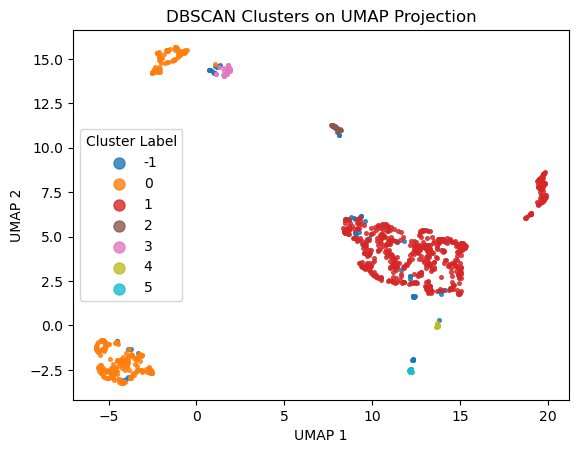

In [61]:
# # plot in 2D UMAP space
# model = umap.UMAP(n_components=2, random_state=random_seed)
# X_reduced = model.fit_transform(X_scaled)
# # Plot clusters
# plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=labels, cmap='tab10', s=5)
# plt.title('DBSCAN Clusters on UMAP Projection')
# plt.xlabel('UMAP 1')
# plt.ylabel('UMAP 2')
# plt.legend()
# plt.show()

model = umap.UMAP(n_components=2, random_state=random_seed)
X_reduced = model.fit_transform(X_scaled)

unique_labels = np.unique(labels)
cmap = plt.get_cmap('tab10', len(unique_labels))

for i, label in enumerate(unique_labels):
    mask = labels == label
    plt.scatter(X_reduced[mask, 0], X_reduced[mask, 1], 
                c=[cmap(i)], label=str(label), s=7, alpha=0.8)

plt.title('DBSCAN Clusters on UMAP Projection')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.legend(title="Cluster Label", markerscale=3)
plt.show()

## With dimensionality reduction

## UMAP + DBSCAN

/home/jko/miniconda3/envs/torch/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



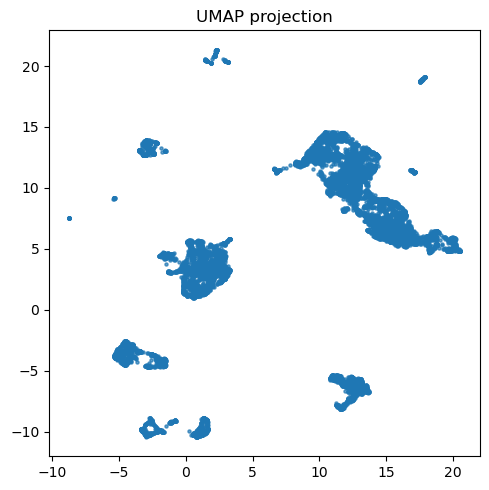

In [6]:
# Try clustering with no dimensionality reduction
n_subset = 10000
random_seed = 666
df_subset = df.sample(n_subset, random_state=random_seed)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_subset)
n_components = 2

# UMAP
umap_model = umap.UMAP(n_components=n_components, random_state=42)
X_umap = umap_model.fit_transform(X_scaled)

# Plotting
fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(X_umap[:, 0], X_umap[:, 1], s=5, alpha=0.7)
ax.set_title('UMAP projection')
plt.tight_layout()
plt.show()

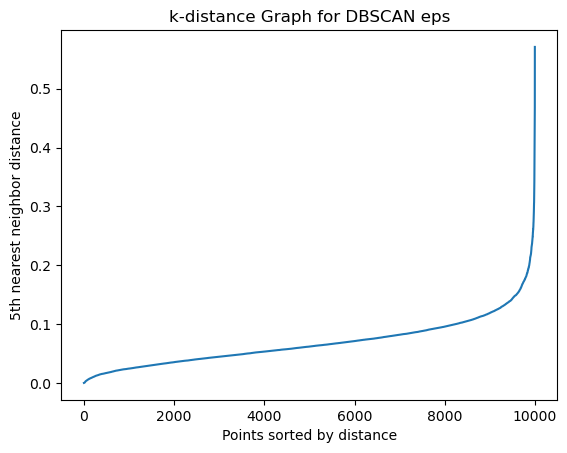

In [7]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt

k = 5  # usually set to min_samples
nbrs = NearestNeighbors(n_neighbors=k).fit(X_umap)
distances, indices = nbrs.kneighbors(X_umap)
k_distances = np.sort(distances[:, k-1])

plt.plot(k_distances)
plt.xlabel('Points sorted by distance')
plt.ylabel(f'{k}th nearest neighbor distance')
plt.title('k-distance Graph for DBSCAN eps')
plt.show()

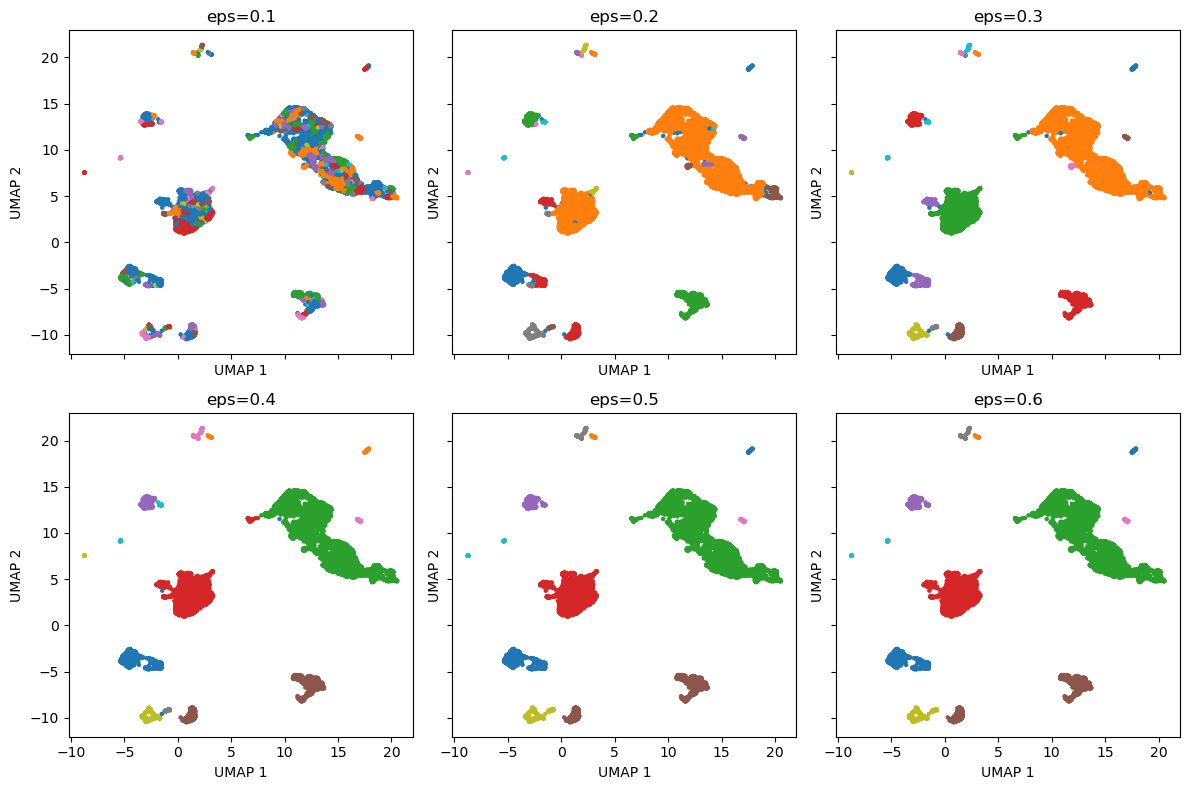

In [13]:
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
import numpy as np

eps_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
fig, axes = plt.subplots(2, 3, figsize=(12, 8), sharex=True, sharey=True)
axes = axes.flatten()

for i, eps in enumerate(eps_values):
    clustering = DBSCAN(eps=eps, min_samples=5)
    labels = clustering.fit_predict(X_umap)
    ax = axes[i]
    scatter = ax.scatter(X_umap[:, 0], X_umap[:, 1], c=labels, cmap='tab10', s=5)
    ax.set_title(f'eps={eps}')
    ax.set_xlabel('UMAP 1')
    ax.set_ylabel('UMAP 2')

# Hide any unused subplots if eps_values < 6
for j in range(len(eps_values), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

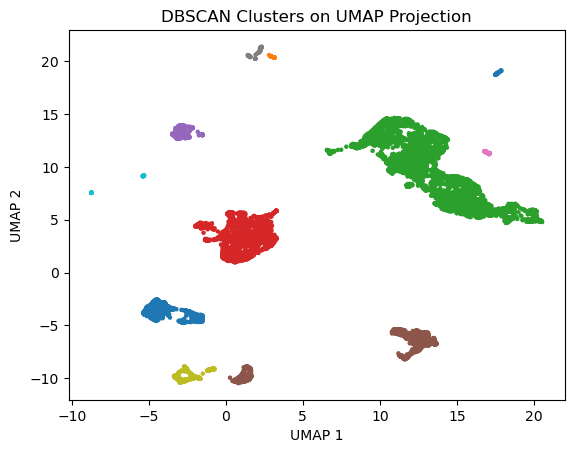

In [14]:
from sklearn.cluster import DBSCAN

# Use UMAP-reduced data for clustering (you can also use X_tsne)
clustering = DBSCAN(eps=0.5, min_samples=5)
labels = clustering.fit_predict(X_umap)

# Plot clusters
import matplotlib.pyplot as plt
plt.scatter(X_umap[:, 0], X_umap[:, 1], c=labels, cmap='tab10', s=5)
plt.title('DBSCAN Clusters on UMAP Projection')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()